In [ ]:
%cd /content/drive/My Drive/Project/Pytorch Tutorial

/content/drive/My Drive/Project/Pytorch Tutorial


## Transfer Learning for Computer Vision Tutorial

Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. [Source](https://en.wikipedia.org/wiki/Transfer_learning)

These two major transfer learning scenarios look as follows:

1.   Finetuning the convnet: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
2.   ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [ ]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import copy

plt.ion()  #interactive mode

### Load Data


We will use torchvision and torch.utils.data packages for loading data.

goals for this model is to classify ants and bees. We have about 120 training images each for ants and bees. there are 75 validation images for each class.

This dataset is a very small subset of imagenet.

You can download dataset [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [ ]:
# !unzip "hymenoptera_data.zip"

In [ ]:
data_transforms = {
    'train' : transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
    ]),
    'val': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
BATCH_SIZE = 4
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images

(228, 906, 3)


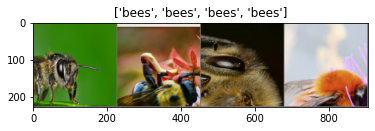

In [ ]:
def imshow(inp, title = None):
  # imshow for Tensor
  inp = inp.numpy().transpose((1, 2, 0))
  print(inp.shape)
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

#get batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

1.    Scheduling the learning rate
2.    Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the Convnet

Load a pretrained model and reset final fully connected layer.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### Train and Evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5221 Acc: 0.7787
val Loss: 0.2304 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.6105 Acc: 0.7541
val Loss: 0.3004 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5348 Acc: 0.7705
val Loss: 0.2292 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4019 Acc: 0.8443
val Loss: 0.2116 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4235 Acc: 0.8443
val Loss: 0.3224 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.5821 Acc: 0.7746
val Loss: 0.5915 Acc: 0.8105

Epoch 6/24
----------
train Loss: 0.6576 Acc: 0.7746
val Loss: 1.2909 Acc: 0.5556

Epoch 7/24
----------
train Loss: 0.5004 Acc: 0.7951
val Loss: 0.2257 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3517 Acc: 0.8402
val Loss: 0.2235 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3183 Acc: 0.8730
val Loss: 0.2125 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2876 Acc: 0.8770
val Loss: 0.2286 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2802 Acc: 0.8893
val Loss: 0.1991 Acc: 0.9412

Ep

(224, 224, 3)


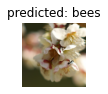

(224, 224, 3)


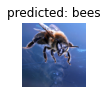

(224, 224, 3)


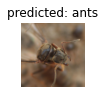

(224, 224, 3)


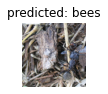

(224, 224, 3)


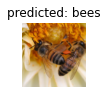

(224, 224, 3)


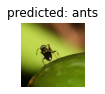

In [ ]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set ``requires_grad == False `` to freeze the parameters so that the gradients are not computed in ``backward().``

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6571 Acc: 0.6475
val Loss: 0.2533 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4070 Acc: 0.7992
val Loss: 0.1714 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.5435 Acc: 0.7869
val Loss: 0.3730 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.5594 Acc: 0.7664
val Loss: 0.1692 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3844 Acc: 0.8525
val Loss: 0.1790 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4805 Acc: 0.8197
val Loss: 0.1998 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3780 Acc: 0.8238
val Loss: 0.2689 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3902 Acc: 0.8156
val Loss: 0.1953 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3441 Acc: 0.8648
val Loss: 0.2292 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3172 Acc: 0.8811
val Loss: 0.2085 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3384 Acc: 0.8566
val Loss: 0.2763 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3097 Acc: 0.8689
val Loss: 0.2263 Acc: 0.9281

Ep